## Notebook libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from datetime import datetime
import glob
import random as rnd

import h5py

import requests
from bs4 import BeautifulSoup

import gzip
import shutil

years = range(2004, 2025)

## Download compressed (gz) HDF files 2004-2024

In [2]:
%%time
root_dir = 'D:/IceDyno/IMS Images'
for yr in years:
    print(f'Downloading files for {yr}')
    save_dir = f'{root_dir}/{yr}/'
    os.makedirs(save_dir, exist_ok=True)
    
    html_page = f'https://polarwatch.noaa.gov/erddap/files/usnic_ims_4km/{yr}/'
    response = requests.get(html_page)

    try:
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            links = soup.find_all('a')
            file_cnt = 0
            for link in links:
                href = link.get('href')
                if '.gz' in href:
                    download_url = f"{html_page}/{link['href']}"
                    response = requests.get(download_url, stream=True)
                    response.raise_for_status()
                    
                    file_name = f'{save_dir}/{os.path.basename(download_url)}'
                    
                    with open(file_name, 'wb') as file:
                        for chunk in response.iter_content(chunk_size=512):
                            file.write(chunk)
                            
                    file_cnt += 1
                    if file_cnt % 50 == 0:
                        print(f'Downloading files for {yr}: [{file_cnt}]')
                        
                    

    except requests.exceptions.RequestException as e:
        print(f'Error: {e}')
        
    print(f'Total downloaded files for {yr}: [{file_cnt}]\n')

Total downloaded files for 2004: [310]
Total downloaded files for 2005: [361]
Total downloaded files for 2006: [361]
Total downloaded files for 2007: [363]
Total downloaded files for 2008: [365]
Total downloaded files for 2009: [364]
Total downloaded files for 2010: [365]
Total downloaded files for 2011: [365]
Total downloaded files for 2012: [366]
Total downloaded files for 2013: [365]
Total downloaded files for 2014: [358]
Total downloaded files for 2015: [364]
Total downloaded files for 2016: [366]
Total downloaded files for 2017: [363]
Total downloaded files for 2018: [365]
Total downloaded files for 2019: [335]
Total downloaded files for 2020: [366]
Total downloaded files for 2021: [365]
Total downloaded files for 2022: [293]
Total downloaded files for 2023: [365]
Total downloaded files for 2024: [52]
CPU times: total: 19min 38s
Wall time: 2h 43min 23s


## Extract HDF files

In [ ]:
for yr in years:
    print(f'Extracting HDF files for {yr}')
    dir_path = f'D:/IceDyno/IMS Images/{yr}'
    files = os.listdir(dir_path)
    gz_files = [file for file in files if file.endswith('.gz')]
    file_cnt = 0
    
    for gz_file in gz_files:
        gz_file_path = f'{dir_path}/{gz_file}'
        hdf_file_path = os.path.splitext(gz_file_path)[0]
        
        if os.path.exists(hdf_file_path): os.remove(hdf_file_path)
        with gzip.open(gz_file_path, 'rb') as comp_file:
            with open(hdf_file_path, 'wb') as hdf_file:
                shutil.copyfileobj(comp_file, hdf_file)
        
        file_cnt += 1     
        if file_cnt % 100 == 0:
            print(f'Extracting HDF files for {yr}: [{file_cnt}]')
            
    print(f'Total extracted HDF files for {yr}: [{file_cnt}]\n')

## Open HDF file and save image

In [21]:
def print_image(data, title, show_legend):
    rotated_data = np.rot90(data, 2)

    # Define a custom colormap with five colors
    """
    0 (outside Northern Hemisphere).
    1 (open water)
    2 (land without snow)
    3 (sea or lake ice)
    4 (snow covered land)
    """
    colors = ['#E500E5', '#0066FF', '#01FF00', '#FFC100', '#E50000']
    cmap = ListedColormap(colors, name='custom_colormap', N=len(colors))
    
    inner_level = 2200
    # Select the inner portion of the rotated data
    start_row = (rotated_data.shape[0] - inner_level) // 2
    end_row = start_row + inner_level
    start_col = (rotated_data.shape[1] - inner_level) // 2
    end_col = start_col + inner_level
    inner_data = rotated_data[start_row:end_row, start_col:end_col]

    # Flip to match mapo on PolarWatch website
    flipped_data = np.fliplr(inner_data)
    
    # Display the image using imshow with the custom colormap
    plt.imshow(flipped_data, cmap=cmap, vmin=0, vmax=len(colors) - 1)
    plt.title(title)
    
    if show_legend:
        colorbar = plt.colorbar(ticks=np.arange(len(colors)), label='Surface Type')
        colorbar.set_ticklabels(['Outside Northern Hemisphere', 'Open Water', 'Land without Snow',
                                 'Sea or Lake Ice', 'Snow Covered Land'])

    return plt

def convert_datetime(date_string):
    return datetime.strptime(date_string, '%B %d, %Y')

def prepare_data(data):
    rotated_data = np.rot90(data, 2)
    
    inner_level = 2200
    # Select the inner portion of the rotated data
    start_row = (rotated_data.shape[0] - inner_level) // 2
    end_row = start_row + inner_level
    start_col = (rotated_data.shape[1] - inner_level) // 2
    end_col = start_col + inner_level
    inner_data = rotated_data[start_row:end_row, start_col:end_col]

    # Flip to match mapo on PolarWatch website
    flipped_data = np.fliplr(inner_data)
    
    return flipped_data

## Display 10 days for each year

C:\Users\brend\AppData\Local\Temp\ipykernel_24460\1989621914.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['Outside Northern Hemisphere', 'Open Water',


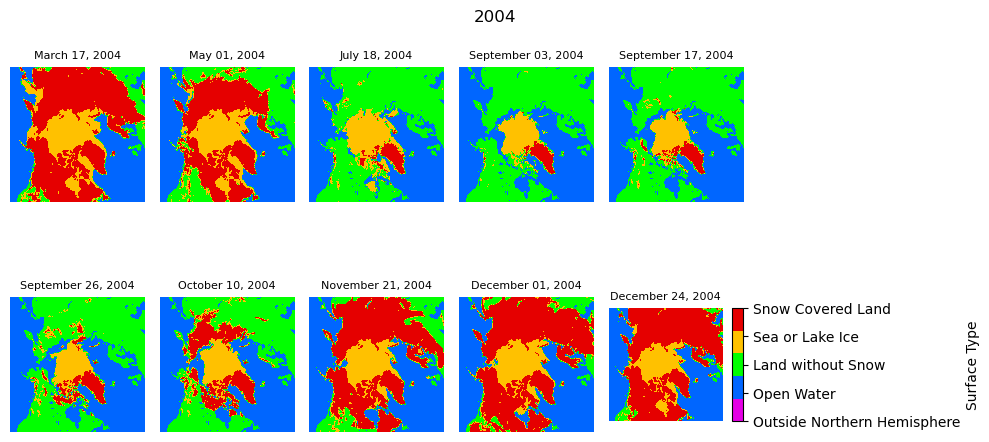

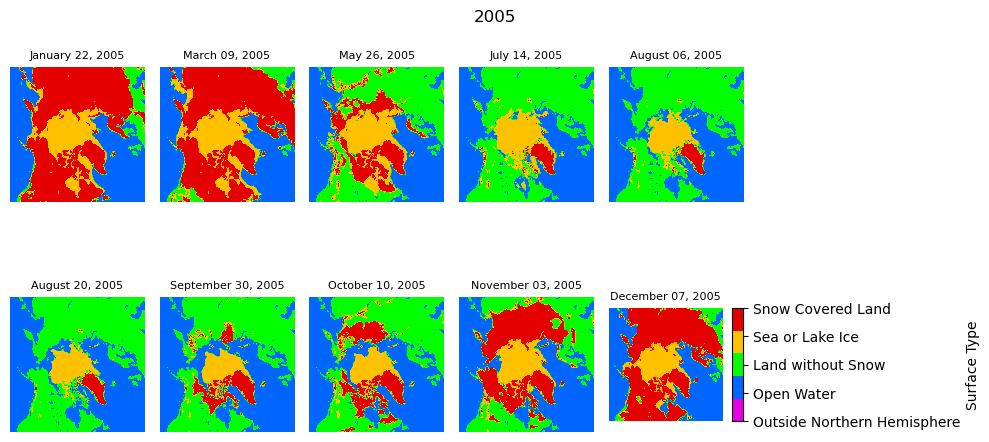

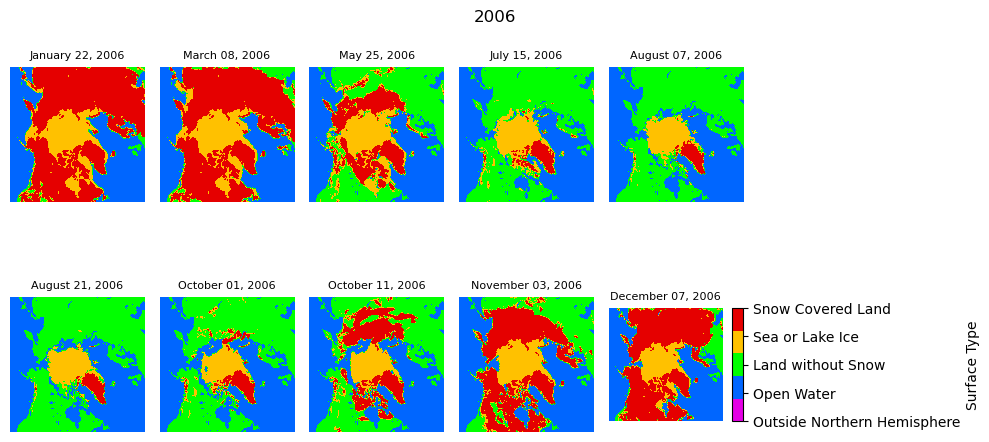

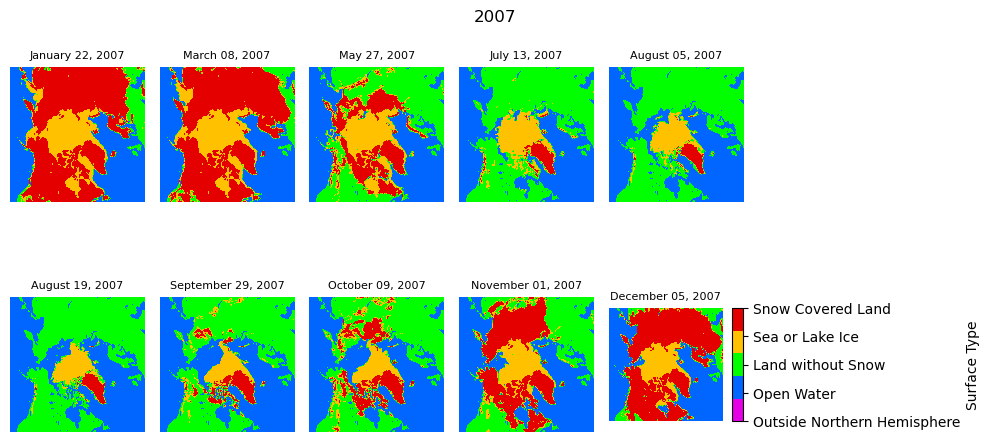

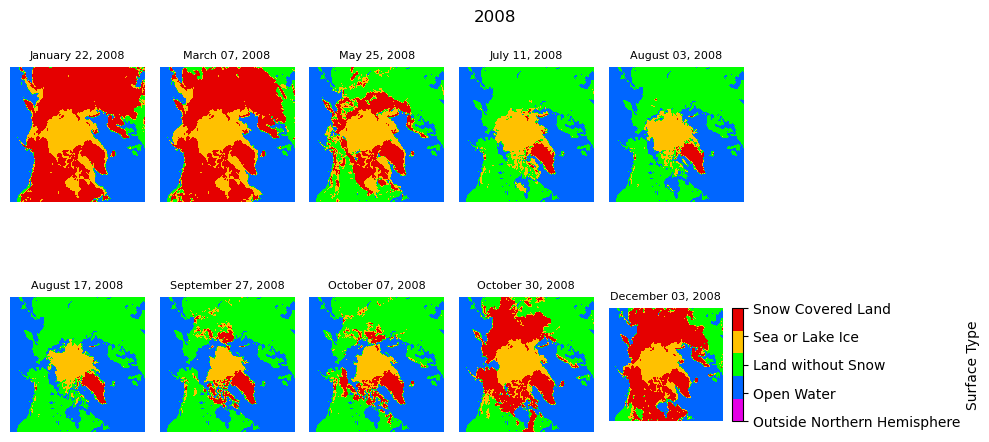

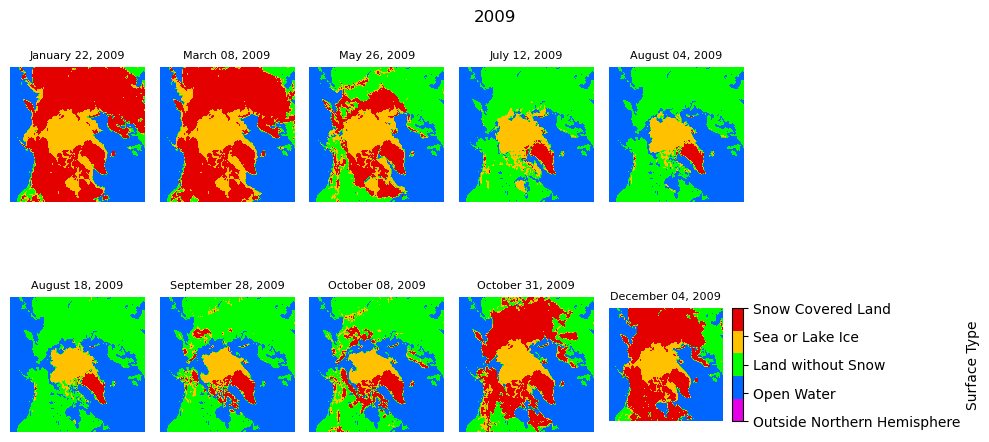

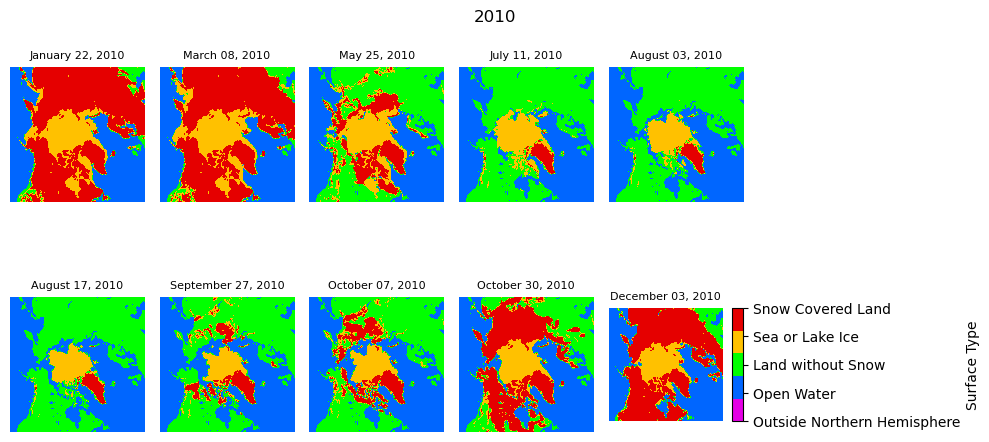

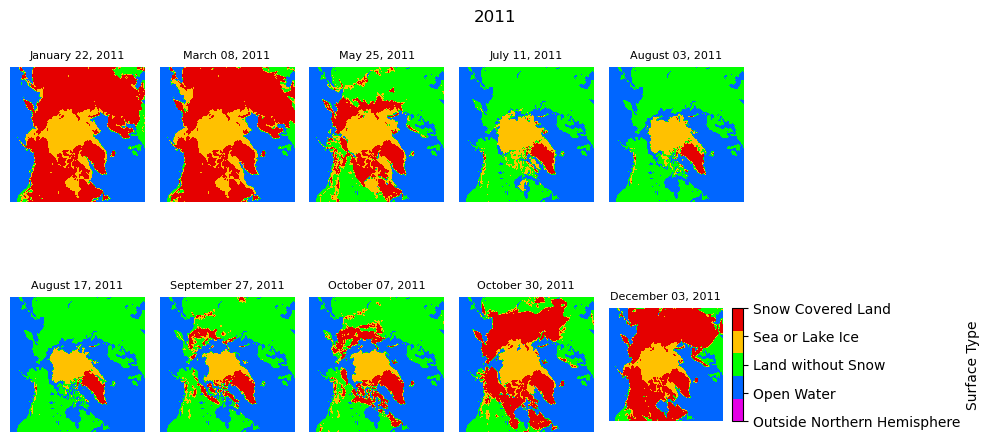

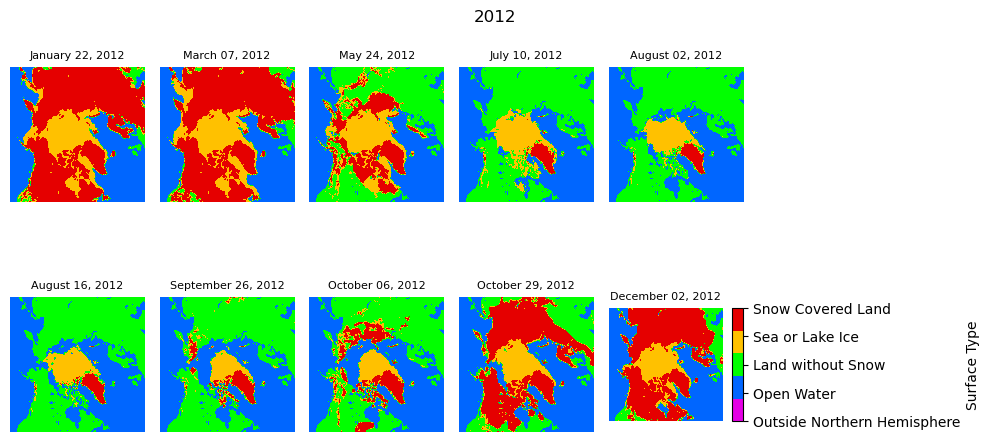

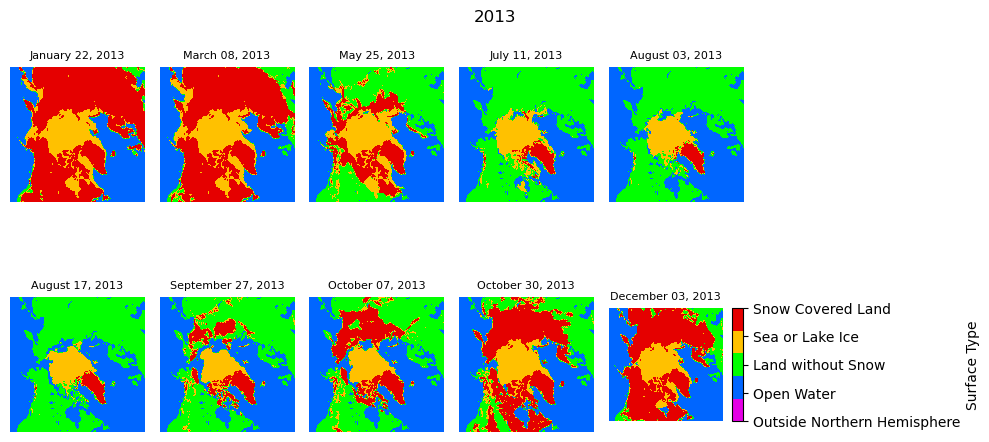

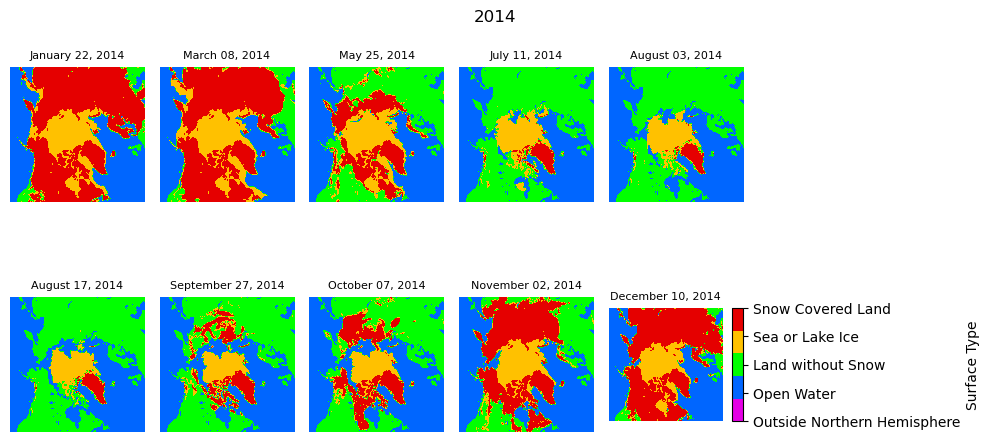

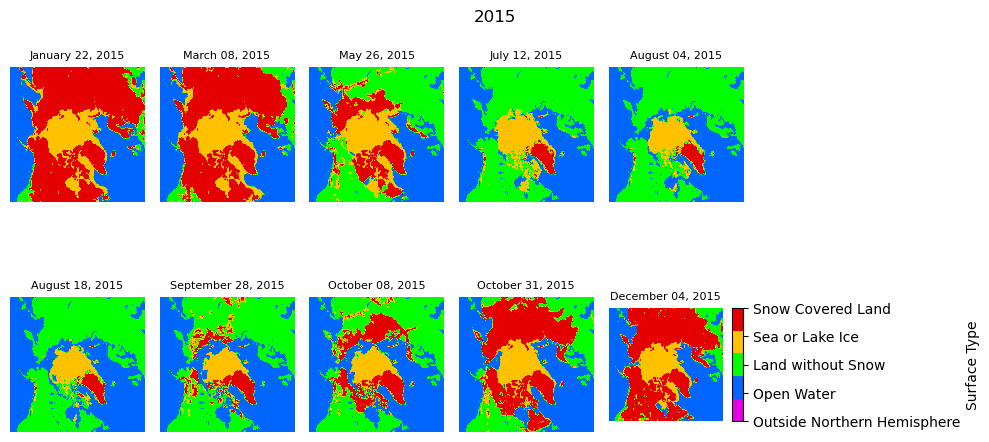

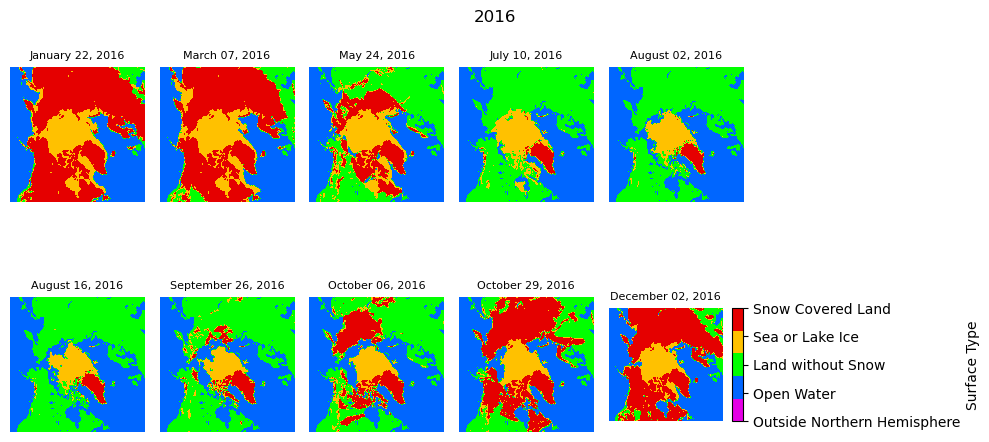

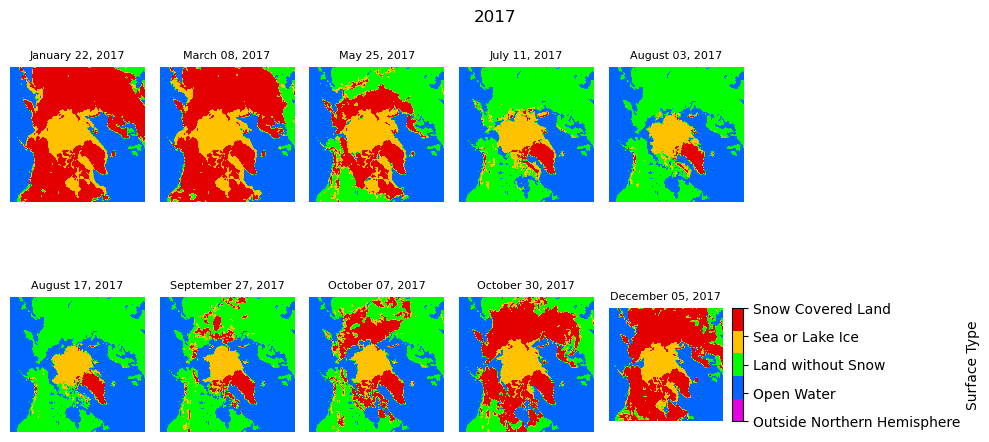

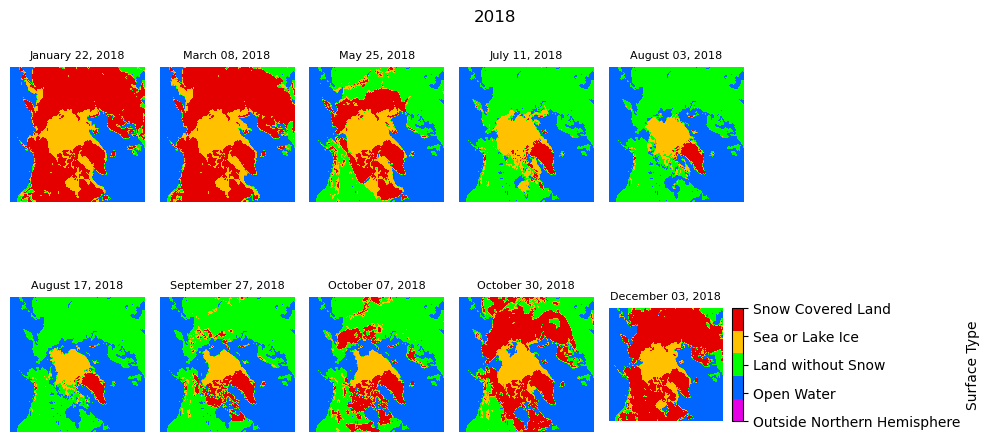

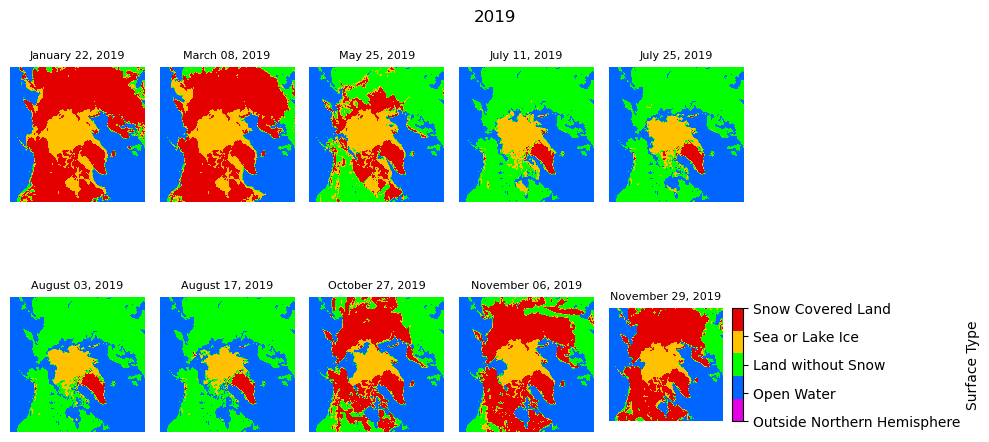

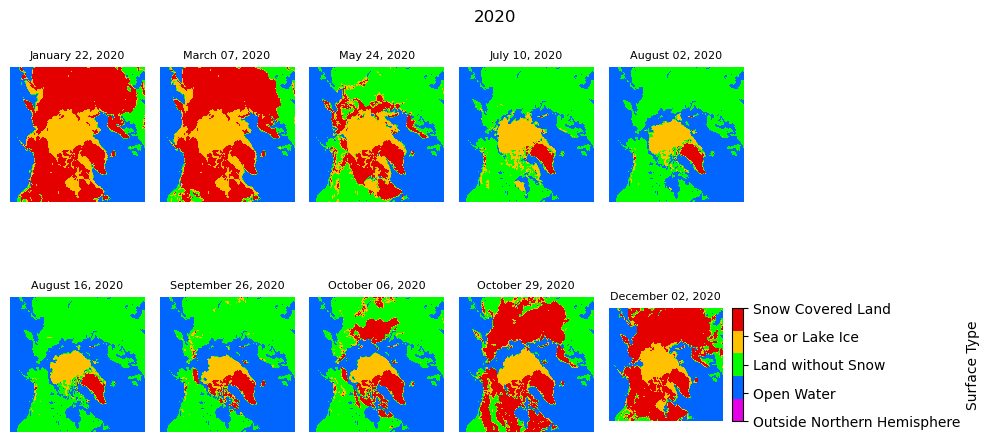

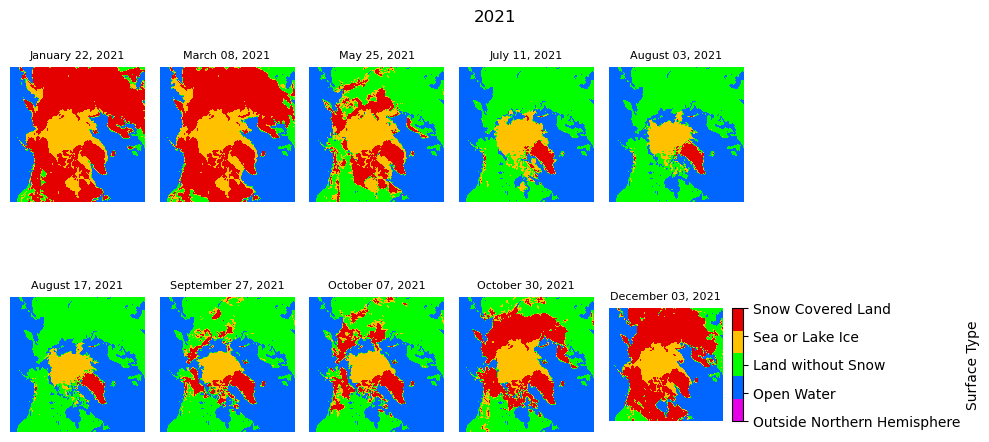

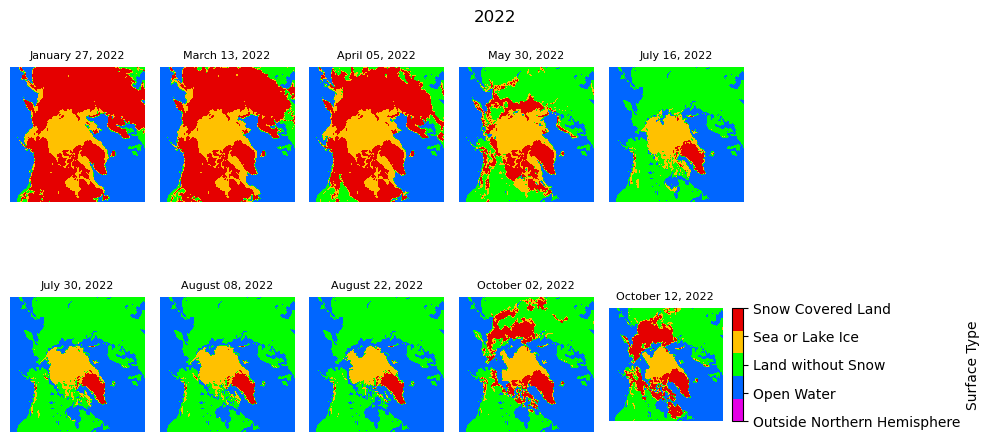

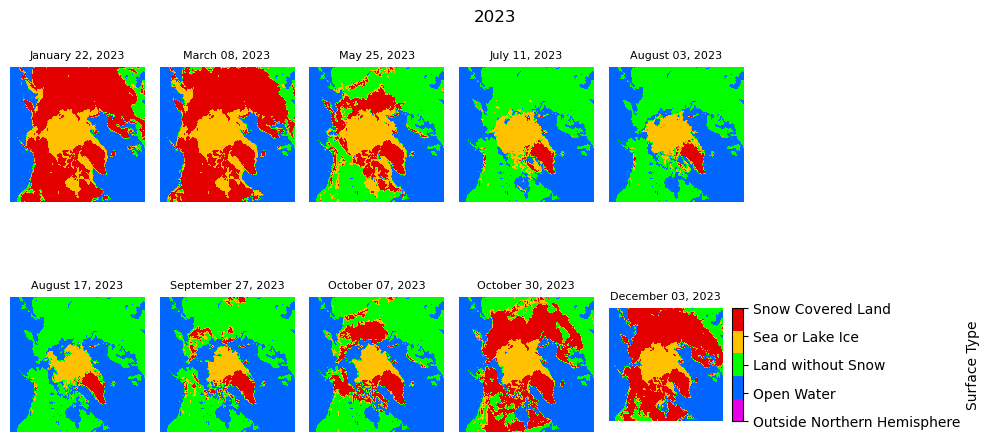

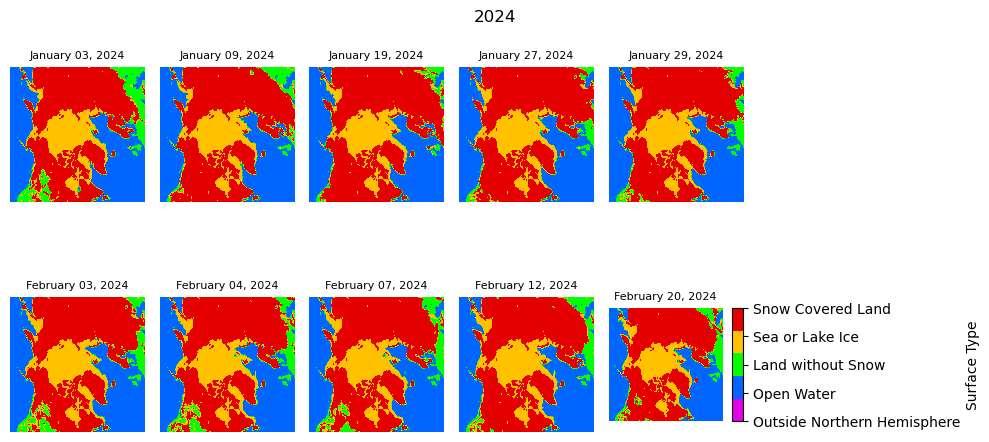

In [79]:
# Define a custom colormap with five colors
"""
0 (outside Northern Hemisphere).
1 (open water)
2 (land without snow)
3 (sea or lake ice)
4 (snow covered land)
"""
colors = ['#E500E5', '#0066FF', '#01FF00', '#FFC100', '#E50000']
cmap = ListedColormap(colors, name='custom_colormap', N=len(colors))

for yr in years:
    image_arrays = {}
    hdf_dir = f'D:/IceDyno/IMS Images/{yr}'
    for i, hdf_file in enumerate(glob.glob(f'{hdf_dir}/*.nc')):
        with h5py.File(hdf_file, 'r') as file:
            
            # Time stamp
            dataset = file['time']
            timestamp = dataset[0]
            dt_object = datetime.utcfromtimestamp(timestamp)
            formatted_date = dt_object.strftime("%B %d, %Y")
            
            # Image array
            dataset = file['IMS_Surface_Values']
            data = dataset[0]
            
            image_arrays[formatted_date] = data
            
            
    # Show random dates
    rnd.seed(31415)
    rnd_dates = rnd.sample(list(image_arrays.keys()), 10)
    rnd_dates = sorted(rnd_dates, key=convert_datetime)
    
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))
    axs = axs.flatten()
    
    for i, img_date in enumerate(rnd_dates):
        axs[i].imshow(prepare_data(image_arrays[img_date]), cmap=cmap, vmin=0, vmax=len(colors) - 1)
        axs[i].set_title(img_date, fontsize=8)
        axs[i].axis('off')
            
    divider = make_axes_locatable(axs[len(rnd_dates)-1])
    cbar_ax = divider.append_axes("right", size="10%", pad=0.1)
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.ax.set_yticklabels(['Outside Northern Hemisphere', 'Open Water',
                             'Land without Snow', 'Sea or Lake Ice', 'Snow Covered Land'])
    cbar.set_label('Surface Type')

    plt.tight_layout()
    plt.suptitle(yr)
    plt.show()
        
    
# Clear memory
image_arrays = None